In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import statsmodels.api as sm
import qgrid
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from IPython.display import HTML, display
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pylab import rcParams
from datetime import date
from datetime import timedelta

#         Tennessee COVID-19 Forecaster

In [74]:
dataset = pd.read_csv("tn_covid.csv")
df = pd.DataFrame(dataset)

dataset = dataset.drop(dataset.columns[2], axis=1)

death_dataset = pd.read_csv("tn_covid.csv")
df = pd.DataFrame(death_dataset)
death_dataset = death_dataset.drop(death_dataset.columns[1], axis=1)

In [75]:
death_dataset

,date,deaths
0,1/22/2020,0
1,1/23/2020,0
2,1/24/2020,0
3,1/25/2020,0
4,1/26/2020,0
...,...,...
354,1/10/2021,7785
355,1/11/2021,7865
356,1/12/2021,8011
357,1/13/2021,8148


In [76]:
df.index = pd.DatetimeIndex(df['date'], freq='D')
df= df.drop(df.columns[0], axis=1)


dataset.index = pd.DatetimeIndex(dataset['date'], freq='D')
dataset = dataset.drop(dataset.columns[0], axis=1)

death_dataset.index = pd.DatetimeIndex(death_dataset['date'], freq='D')
death_dataset = death_dataset.drop(death_dataset.columns[0], axis=1)

#### These graphs show the number of cases and deaths in Tennessee

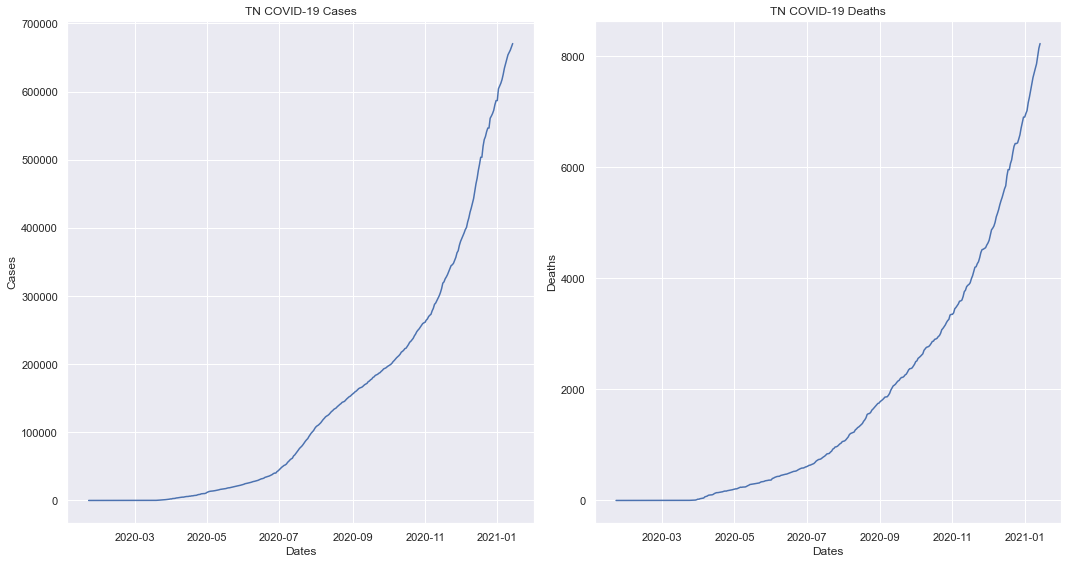

In [77]:
sns.set()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
axes[0].plot(dataset);
axes[0].set(title="TN COVID-19 Cases",
      xlabel="Dates",
      ylabel="Cases")

axes[1].plot(death_dataset)
axes[1].set(title="TN COVID-19 Deaths",
      xlabel="Dates",
      ylabel="Deaths")
fig.tight_layout()

fig.savefig('gtest.png', bbox_inches='tight')

In [78]:
import qgrid
qgrid_widget = qgrid.show_grid(df)

In [79]:
y = dataset
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
# print(results.summary().tables[1])

In [80]:
z = death_dataset
mod = sm.tsa.statespace.SARIMAX(z,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
death_results = mod.fit()

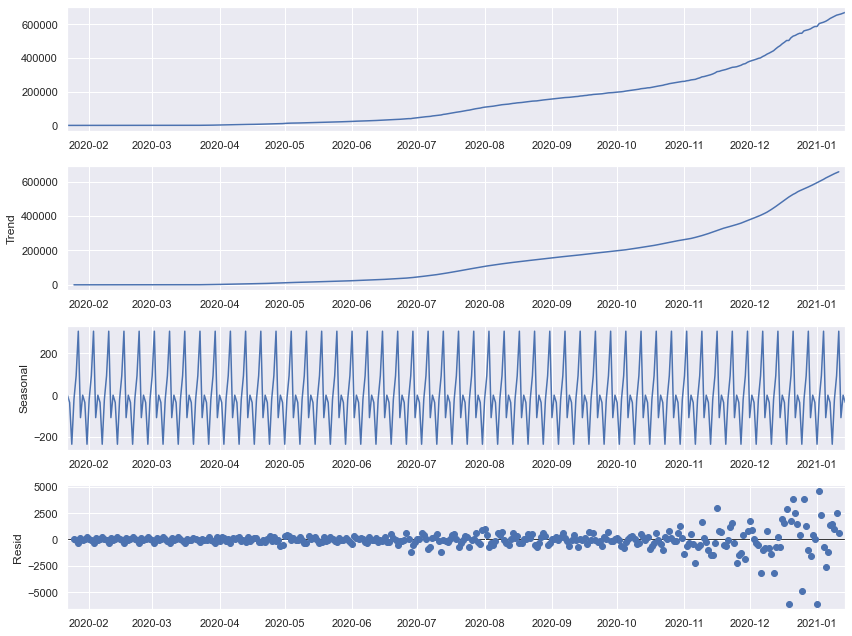

In [81]:
rcParams['figure.figsize'] = 12, 9
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

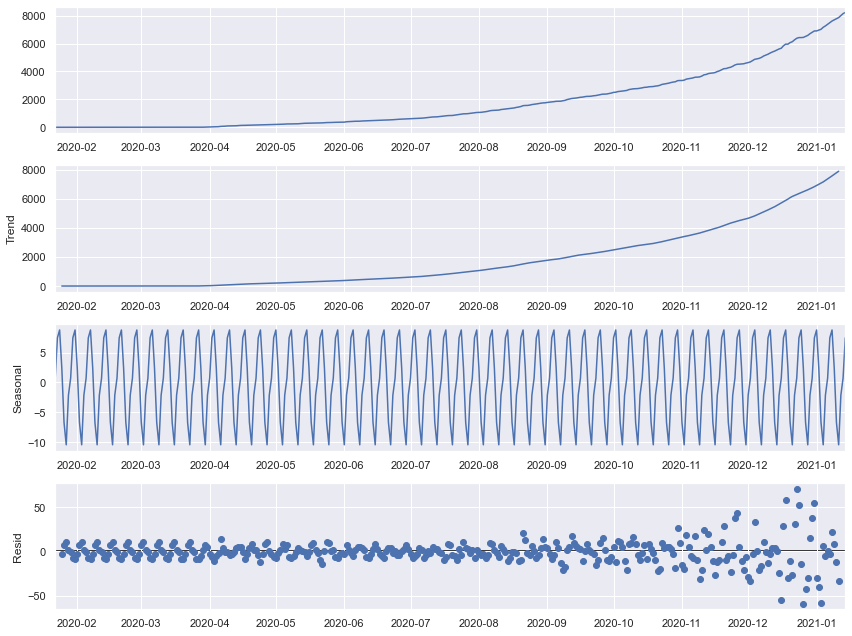

In [82]:
rcParams['figure.figsize'] = 12, 9
decomposition = sm.tsa.seasonal_decompose(z, model='additive')
fig = decomposition.plot()
plt.show()

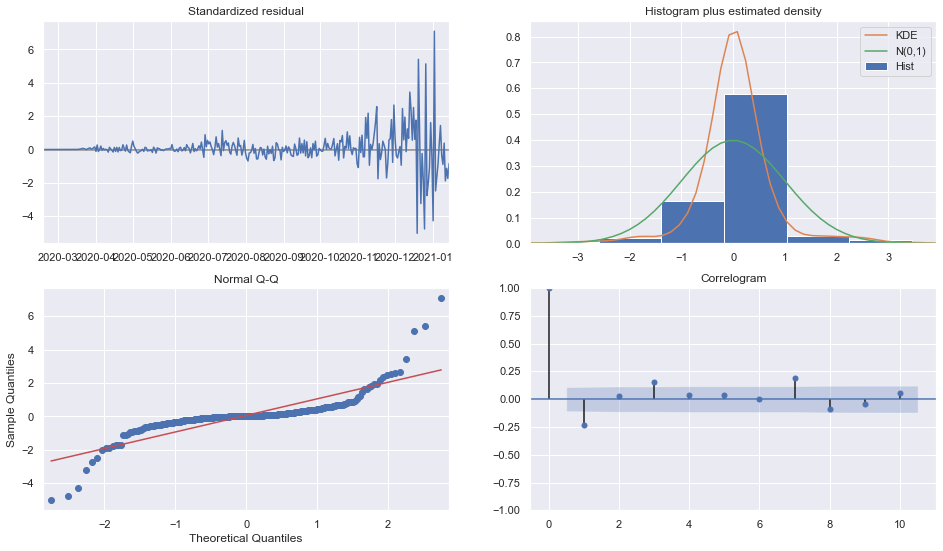

In [83]:
results.plot_diagnostics(figsize=(16, 9))
plt.show()

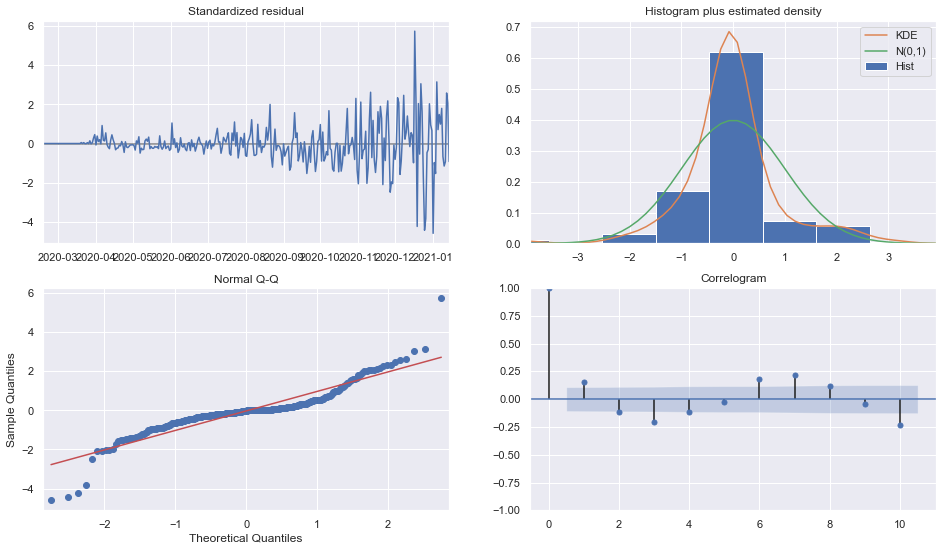

In [84]:
death_results.plot_diagnostics(figsize=(16, 9))
plt.show()

In [85]:
# Perform Dickey-Fuller test:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(dataset['cases'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   1.865577
p-value                          0.998471
#Lags Used                      14.000000
Number of Observations Used    344.000000
Critical Value (1%)             -3.449503
Critical Value (5%)             -2.869979
Critical Value (10%)            -2.571266
dtype: float64


In [86]:
# Perform Dickey-Fuller test:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(death_dataset['deaths'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   4.418678
p-value                          1.000000
#Lags Used                      14.000000
Number of Observations Used    344.000000
Critical Value (1%)             -3.449503
Critical Value (5%)             -2.869979
Critical Value (10%)            -2.571266
dtype: float64


             lower cases   upper cases
2021-01-15  6.731859e+05  6.794216e+05
2021-01-16  6.769907e+05  6.864475e+05
2021-01-17  6.811321e+05  6.935049e+05
2021-01-18  6.849832e+05  7.001906e+05
2021-01-19  6.904630e+05  7.085008e+05
...                  ...           ...
2021-06-09  1.069472e+06  2.123608e+06
2021-06-10  1.070316e+06  2.135954e+06
2021-06-11  1.071100e+06  2.148288e+06
2021-06-12  1.073456e+06  2.162241e+06
2021-06-13  1.074059e+06  2.174485e+06

[150 rows x 2 columns]


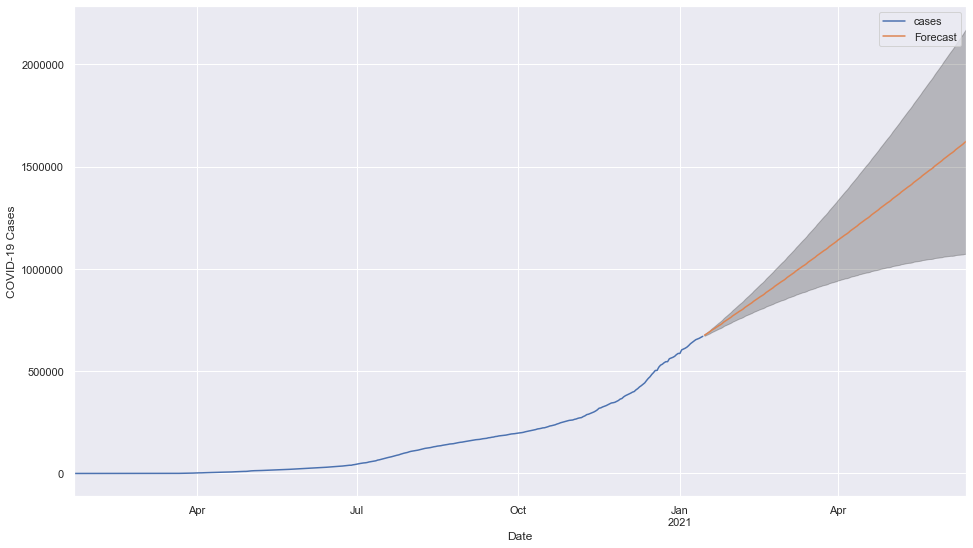

In [87]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

pred = results.get_forecast(steps=150)

pred_ci = pred.conf_int()

print(pred_ci)

ax = y.plot(label='observed', figsize=(16, 9), use_index=True)
pred.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('COVID-19 Cases')
ax.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.legend()
plt.show();

AxesSubplot(0.125,0.125;0.775x0.755)


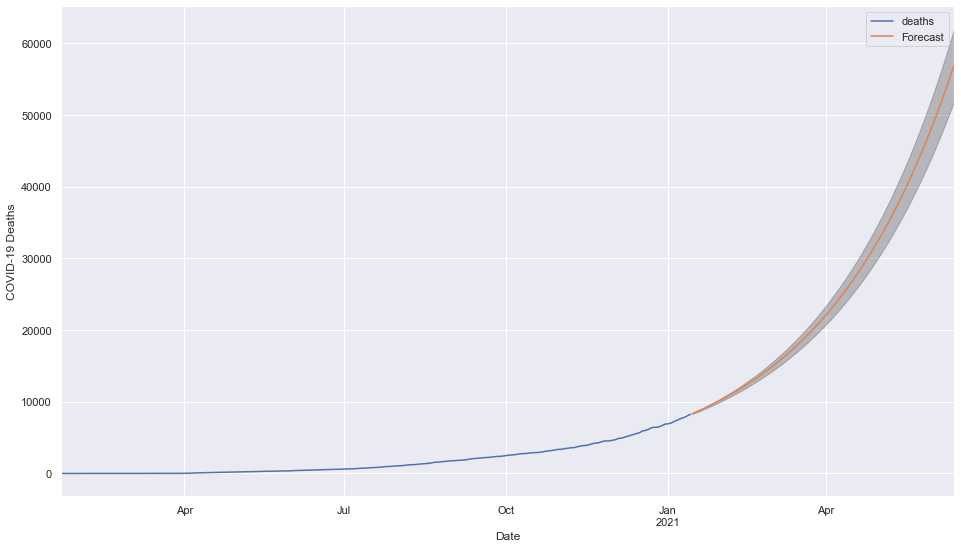

In [88]:
pred = death_results.get_forecast(steps=150)

pred_ci = pred.conf_int()

ax = z.plot(label='observed', figsize=(16, 9))
print(ax)
pred.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('COVID-19 Deaths')
plt.legend()
plt.show();

In [89]:
forecast = results.forecast(400)

forecastDf = pd.DataFrame(forecast)

In [90]:
death_forecast = death_results.forecast(400)

death_forecastDf = pd.DataFrame(death_forecast)

In [91]:
# forecastDf

In [92]:
# forecastDf.loc['2021-07-06 00:00:00']

In [93]:
# forecastDf

In [94]:
# guess todays cases
today = pd.to_datetime('today').normalize()

p_today = round(forecastDf.loc[today][0])

print(f'The estimated total cases of COVID-19 in '
      f'Tennessee today is..{p_today}')

The estimated total cases of COVID-19 in Tennessee today is..710503.0


In [95]:
# guess todays deaths
today = pd.to_datetime('today').normalize()

p_today = round(death_forecastDf.loc[today][0])

print(f'The estimated total deaths from COVID-19 in '
      f'Tennessee today is..{p_today}')

The estimated total deaths from COVID-19 in Tennessee today is..8995.0


In [96]:
# guess next weeks cases
today = pd.to_datetime('today').normalize()

week = today + timedelta(days=7)

p_week = round(forecastDf.loc[week][0])

print(f'The estimated total cases of COVID-19 in '
      f'Tennessee next week is..{p_week}')

The estimated total cases of COVID-19 in Tennessee next week is..751666.0


In [97]:
# guess next weeks deaths
today = pd.to_datetime('today').normalize()

week = today + timedelta(days=7)

p_week = round(death_forecastDf.loc[week][0])

print(f'The estimated total deaths from COVID-19 in '
      f'Tennessee next week is..{p_week}')

The estimated total deaths from COVID-19 in Tennessee next week is..9834.0


In [98]:
# guess next months cases
today = pd.to_datetime('today').normalize()

month = today + timedelta(days=30)

p_month = round(forecastDf.loc[month][0])

print(f'The estimated total cases of COVID-19 in '
      f'Tennessee next month is..{p_month}')

The estimated total cases of COVID-19 in Tennessee next month is..890342.0


In [99]:
# guess next months deaths
today = pd.to_datetime('today').normalize()

month = today + timedelta(days=30)

p_month = round(death_forecastDf.loc[month][0])

print(f'The estimated total deaths from COVID-19 in '
      f'Tennessee next month is..{p_month}')

The estimated total deaths from COVID-19 in Tennessee next month is..13187.0


In [100]:
# guess 3 months cases
today = pd.to_datetime('today').normalize()

three_month = today + timedelta(days=90)

p_three_month = round(forecastDf.loc[three_month][0])

print(f'The estimated total cases of COVID-19 in '
      f'Tennessee next month is..{p_three_month}')

The estimated total cases of COVID-19 in Tennessee next month is..1270424.0


In [101]:
# guess 3 months deaths
today = pd.to_datetime('today').normalize()

three_month = today + timedelta(days=90)

p_three_month = round(death_forecastDf.loc[three_month][0])

print(f'The estimated total deaths from COVID-19 in '
      f'Tennessee next month is..{p_three_month}')

The estimated total deaths from COVID-19 in Tennessee next month is..28582.0


In [102]:
# guess 6 months cases
today = pd.to_datetime('today').normalize()

six_month = today + timedelta(days=180)

p_six_month = round(forecastDf.loc[six_month][0])

print(f'The estimated total cases of COVID-19 in '
      f'Tennessee next month is..{p_six_month}')

The estimated total cases of COVID-19 in Tennessee next month is..1878586.0


In [103]:
# guess 6 months deaths
today = pd.to_datetime('today').normalize()

six_month = today + timedelta(days=180)

p_six_month = round(death_forecastDf.loc[six_month][0])

print(f'The estimated total deaths from COVID-19 in '
      f'Tennessee next month is..{p_six_month}')

The estimated total deaths from COVID-19 in Tennessee next month is..92344.0


In [104]:
# guess year cases
today = pd.to_datetime('today').normalize()

year = today + timedelta(days=365)

p_year = round(forecastDf.loc[year][0])

print(f'The estimated total cases of COVID-19 in '
      f'Tennessee next year is..{p_year}')

The estimated total cases of COVID-19 in Tennessee next year is..3204680.0


In [105]:
# guess year deaths
today = pd.to_datetime('today').normalize()

year = today + timedelta(days=365)

p_year = round(death_forecastDf.loc[year][0])

print(f'The estimated total deaths from COVID-19 in '
      f'Tennessee next year is..{p_year}')

The estimated total deaths from COVID-19 in Tennessee next year is..1046200.0


In [106]:
# forcast_cases = pd.DataFrame([p_today, p_week_out, p_month, p_three_month, p_six_month, p_year])

In [107]:
# forcast_cases

In [108]:
# plot = results.get_prediction(start='2020-08-08', end='2020-12-08')

# plot.predicted_mean

# pred_uc_ci = plot.conf_int(alpha=0.05)

# pred_uc_ci

In [109]:
# dataset

In [110]:
import anvil.server

anvil.server.connect('B3SFXC4ZYK5IPUQYN6HIVZXT-BR2UQIAYA7WD4P4I')

In [111]:
@anvil.server.callable
def read_csv(csv_string):
    # Turn the string into a list for csv_reader.
    csv_list=csv_string.split()
    # Create csv reader instance
    cr=csv.reader(csv_list)
    for csv_line in cr:
        # Each field is [0],[1], etc.
        print(csv_line[0])

In [112]:
import anvil.tables as tables
from anvil.tables import app_tables

def import_csv_data(file):
  with open(file, "r") as f:
    df = pd.read_csv(f)
    for d in df.to_dict(orient="records"):
      # d is now a dict of {columnname -> value} for this row
      # We use Python's **kwargs syntax to pass the whole dict as
      # keyword arguments
      app_tables.cases.add_row(**d)

In [113]:
import_csv_data("tn_covid.csv")

In [114]:
@anvil.server.callable
def get_data():
  return app_tables.cases.search()

In [115]:
@anvil.server.callable
def pc_today():
    # guess todays cases
    today = pd.to_datetime('today').normalize()
    p_today = round(forecastDf.loc[today][0])
    
    return p_today

In [116]:
@anvil.server.callable
def pc_week():
    # guess todays cases
    today = pd.to_datetime('today').normalize()
    
    week = today + timedelta(days=7)
    
    p_week = round(forecastDf.loc[week][0])
    
    return p_week

In [117]:
@anvil.server.callable
def pc_date(date):
    # guess todays cases
    p_today = round(forecastDf.loc[date][0])
    
    return p_today

In [118]:
@anvil.server.callable
def pd_date(date):
    # guess todays cases
    p_today = round(death_forecastDf.loc[date][0])
    
    return p_today

In [119]:
date = '2021-01-21'

p_today = round(forecastDf.loc[date][0])

p_today

710503.0

In [120]:
today = pd.to_datetime('today').normalize()
    
week = today + timedelta(days=365)
    
p_week = round(death_forecastDf.loc[week][0])

p_week

1046200.0

In [121]:
@anvil.server.callable
def get_cases_data():
    dataset = pd.read_csv("tn_covid.csv")
    df = pd.DataFrame(dataset)
    x = dataset['cases'].tolist()
    y = dataset['date'].tolist()
    return x,y

In [122]:
@anvil.server.callable
def get_death_data():
    dataset = pd.read_csv("tn_covid.csv")
    df = pd.DataFrame(dataset)
    x = dataset['deaths'].tolist()
    y = dataset['date'].tolist()
    return x,y

In [123]:
@anvil.server.callable
def get_csv():
    dataset = pd.read_csv("tn_covid.csv")
    return dataset